# Customer Segmentation Part 1 : Business Trend analysis

## Topic

## Objective

## Summary

## Importing libraries

In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from datetime import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, classification_report
import sidetable
sns.set(rc = {'figure.figsize':(15,8)})

Data sets needed : 
- Orders data set
- Orders items data set
- Products data set

## Importing data + Preliminary pre-processing

### Orders dataset

In [179]:
orders_df = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Clients_Clustering\olist_orders_dataset.csv', sep =",")
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [180]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


<AxesSubplot:>

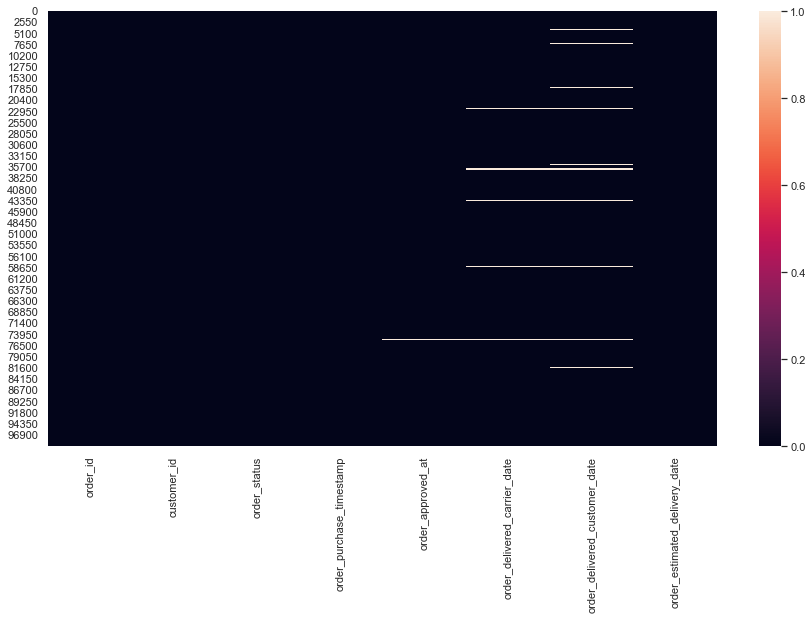

In [181]:
sns.heatmap(orders_df.isnull())

Missing values are not very importan here, the biggest one is about 3% from the time the order was delivred to the customer.

In [182]:
orders_df.describe().transpose()

,count,unique,top,freq
order_id,99441,99441,e481f51cbdc54678b7cc49136f2d6af7,1
customer_id,99441,99441,9ef432eb6251297304e76186b10a928d,1
order_status,99441,8,delivered,96478
order_purchase_timestamp,99441,98875,2018-04-11 10:48:14,3
order_approved_at,99281,90733,2018-02-27 04:31:10,9
order_delivered_carrier_date,97658,81018,2018-05-09 15:48:00,47
order_delivered_customer_date,96476,95664,2018-05-08 23:38:46,3
order_estimated_delivery_date,99441,459,2017-12-20 00:00:00,522


From the table we see that the order id column has 99 441 entries and 99 441 unique values, which means that none of the order ids are repeated. 

In [183]:
orders_df = orders_df.ffill(axis = 1)

I chose to fill out the empty values using pandas ffil, wchich enables you to substitute a missing value with another one. In this case, I prefered to fill them with the value on their left (i.e the date and time at which the previous step of their order was recorded) as opposed to the time of the same step of the previous order in the row. 

In [184]:
def date_time(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d').dt.date
date_time(orders_df,["order_purchase_timestamp","order_approved_at","order_delivered_carrier_date",
                            "order_delivered_customer_date","order_estimated_delivery_date"])
orders_df.sort_values(by = 'order_purchase_timestamp', inplace = True)

In this part, I converted the dates and time columns into datetime format and dropped the time part, because we might combine sales by days later.Then sorted the dataframe because the time line in this case study is important as it reveals about the developement of the business. 

In [185]:
orders_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
4541,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-10-18,2016-10-20
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05,2016-10-07,2016-10-07,2016-10-07,2016-10-28
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13,2016-10-07,2016-10-07,2016-10-07,2016-09-30
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15,2016-11-07,2016-11-09,2016-10-04
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,2016-10-06,2016-10-06,2016-10-06,2016-10-25


Now the dataset is sorted from oldest to soonest sales. This will make it possible to see the development in the business over time.

In [186]:
#orders_df['date_ordinal'] = orders_df['order_purchase_timestamp']\
                           # .apply(lambda date: date.toordinal())

In [187]:
orders_df['shipping_difference'] = orders_df['order_estimated_delivery_date'] - orders_df['order_delivered_customer_date']
orders_df['shipping_duration'] = orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']
orders_df['shipping_est_duration'] = orders_df['order_estimated_delivery_date'] - orders_df['order_purchase_timestamp']

In this part, we added 3 additional columns which seem very much needed for this dataset, they are:
- shipping difference : which is the difference between the estimated and the actual delivery time
- shipping duration : which is the period between the purchase and the final delivery 
- shipping estimated duration: is the period between the purchase and the estimated delivery time

### Order items data set

In [188]:
items_df = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Clients_Clustering\olist_order_items_dataset.csv', sep =",")
items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [189]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [190]:
items_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
order_item_id,112650.0,1.197834,0.705124,1.00,1.00,1.00,1.00,21.00
price,112650.0,120.653739,183.633928,0.85,39.90,74.99,134.90,6735.00
freight_value,112650.0,19.990320,15.806405,0.00,13.08,16.26,21.15,409.68


In [191]:
def date_time(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d').dt.date
date_time(items_df,["shipping_limit_date"])

The order items data set contains orders ids, SKU (Stock Keeping Unit), the seller, price and shipping expense. All the column sare full and there isn't any missing data. The columns are both numerical (3 cols) and catergorical (4 cols).

In [192]:
print("Total of unique order ids in order items ds: {} \n\
Total of unique item ids in order items ds: {} \n\
Total of unique order ids in orders ds: {} \n\
Total of records in order items ds: {}"
      .format(
      items_df["order_id"].nunique(),
      items_df["order_item_id"].nunique(),
      orders_df["order_id"].nunique(),
      len(items_df))
)

Total of unique order ids in order items ds: 98666 
Total of unique item ids in order items ds: 21 
Total of unique order ids in orders ds: 99441 
Total of records in order items ds: 112650


In this part we calculated the unique occurence of instances in the following:
- The number of unique order ids in the order items dataset is 98 666 while the total instances in the datset is 112 650, which mean that there are 13 984 instances reflecting additional items in the some of the same orders.
- The number of unique item ids in the order items dataset is 21, also meaning that some orders contained more than one item. And earlier we saw that the max value of this column is 21 items too.

In [193]:
items_df["order_id"].isin(orders_df["order_id"]).value_counts()

True    112650
Name: order_id, dtype: int64

In [194]:
orders_df["order_id"].isin(items_df["order_id"]).value_counts()

True     98666
False      775
Name: order_id, dtype: int64

The above code tells us the following:
- 775 orders that are present in the orders data set are not present in the order items data set, an explanation might be that they were orders that got cancelled or never delivered.
- All of the instances present in the items data set (112 650 of them) in the orders dat set, meaning that the 13 984 repeated orders that resulted from the purchase of different items at the same time, don't contain any of the missing 775. 

<AxesSubplot:>

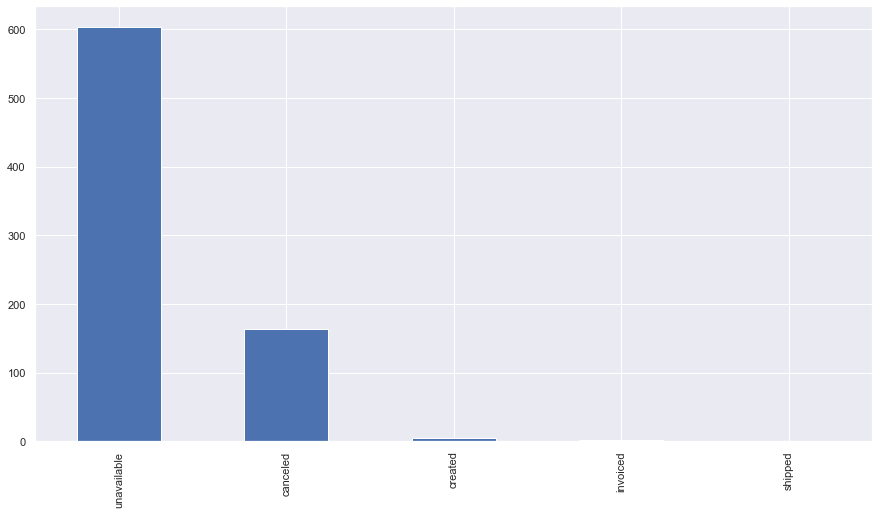

In [195]:
orders_df[~orders_df['order_id'].isin(items_df['order_id'])]['order_status'].value_counts().plot(kind='bar')

Digging a little deeper we see that most orders that were not present in the order items list were listed either unavailable or cancelled, this explains why they aren"t present in the items ds and will therefore be deleted

In [196]:
orders_df = orders_df[orders_df["order_id"].isin(items_df["order_id"])]
print(len(orders_df))

98666


In [197]:
print('Number of duplicated records: {} \n\
Number of duplicated order lines: {}'
    .format(items_df.duplicated().sum(),
    items_df[['order_id', 'product_id']].duplicated().sum()))

Number of duplicated records: 0 
Number of duplicated order lines: 10225


After calculating the sum the duplicate records, we get to the result that none of the records is duplicated (same info in the entire row), but there are 10 225 order ids and product ids that were results of repeating

In [198]:
grouped_df = items_df.groupby(by=["product_id","order_id"], as_index= False).agg({
        'order_item_id': 'count', 
        'seller_id': 'first',
        'shipping_limit_date': 'first',
        'price': 'first',
        'freight_value': 'first'
        })
grouped_df.head()

,product_id,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,00066f42aeeb9f3007548bb9d3f33c38,f30149f4a8882a08895b6a242aa0d612,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-05-24,101.65,18.59
1,00088930e925c41fd95ebfe695fd2655,f5eda0ded77c1293b04c953138c8331d,1,7142540dd4c91e2237acb7e911c4eba2,2017-12-18,129.90,13.93
2,0009406fd7479715e4bef61dd91f2462,0bf736fd0fd5169d60de3699fcbcf986,1,4a3ca9315b744ce9f8e9374361493884,2017-12-29,229.00,13.10
3,000b8f95fcb9e0096488278317764d19,3aba44d8e554ab4bb8c09f6f78032ca8,1,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-16,58.90,19.60
4,000b8f95fcb9e0096488278317764d19,6f0dfb5b5398b271cc6bbd9ee263530e,1,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-07,58.90,19.60


In [199]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   product_id           102425 non-null  object 
 1   order_id             102425 non-null  object 
 2   order_item_id        102425 non-null  int64  
 3   seller_id            102425 non-null  object 
 4   shipping_limit_date  102425 non-null  object 
 5   price                102425 non-null  float64
 6   freight_value        102425 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.5+ MB


The new data set grouped_df represents the order items dataset after grouping it by product id and aggregating the first row for all column except that of order_item_id (which is the amount of articles) which represents the sum of all articles ordered at the same time.

In [200]:
print('Unique order ids in new table: {} \n\
Unique order ids in old table: {} \n\
Unique product ids in new table: {} \n\
Unique product ids in old table: {} \n\
Total quantity in new table: {} \n\
Total quantity in old table: {}'
    .format(
    len(grouped_df['order_id'].unique()),
    len(items_df['order_id'].unique()),
    len(grouped_df['product_id'].unique()),
    len(items_df['product_id'].unique()),
    grouped_df['order_item_id'].sum(),
    len(items_df)
    ))

Unique order ids in new table: 98666 
Unique order ids in old table: 98666 
Unique product ids in new table: 32951 
Unique product ids in old table: 32951 
Total quantity in new table: 112650 
Total quantity in old table: 112650


Here we were just checking that there was no data loss during the transformations, everything seems great. We'll rename the column order item id 

In [201]:
grouped_df.rename(columns = {'order_item_id': 'quantity'}, inplace = True)
grouped_df["quantity"].value_counts()

1     95337
2      5382
3       953
4       390
6       172
5       168
10        5
7         4
12        2
9         2
15        2
14        2
8         2
20        2
11        1
13        1
Name: quantity, dtype: int64

This shows us how many orders were processed containing different quantities of articles

In [202]:
grouped_df["quantity"].mean()

1.0998291432755676

The mean of the column also seems logical for an ecommerce distribution business

## Merging the orders and order items data sets

In [203]:
orders_items = orders_df.merge(grouped_df, on= "order_id")
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_difference,shipping_duration,shipping_est_duration,product_id,quantity,seller_id,shipping_limit_date,price,freight_value
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-10-18,2016-10-20,2 days,44 days,46 days,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-26,39.99,31.67
1,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-10-18,2016-10-20,2 days,44 days,46 days,f293394c72c9b5fafd7023301fc21fc2,1,1554a68530182680ad5c8b042c3ab563,2016-10-26,32.90,31.67
2,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05,2016-10-07,2016-10-07,2016-10-07,2016-10-28,21 days,32 days,53 days,f3c2d01a84c947b078e32bbef0718962,1,a425f92c199eb576938df686728acd20,2016-09-19,59.50,15.56
3,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-09-15,2016-11-07,2016-11-09,2016-10-04,-36 days,55 days,19 days,5a6b04657a4c5ee34285d1e4619a96b4,3,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19,44.99,2.83
4,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,2016-10-06,2016-10-06,2016-10-06,2016-10-25,19 days,4 days,23 days,d2998d7ced12f83f9b832f33cf6507b6,1,25e6ffe976bd75618accfe16cefcbd0d,2016-10-21,100.00,9.34


In [204]:
orders_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102425 entries, 0 to 102424
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       102425 non-null  object         
 1   customer_id                    102425 non-null  object         
 2   order_status                   102425 non-null  object         
 3   order_purchase_timestamp       102425 non-null  object         
 4   order_approved_at              102425 non-null  object         
 5   order_delivered_carrier_date   102425 non-null  object         
 6   order_delivered_customer_date  102425 non-null  object         
 7   order_estimated_delivery_date  102425 non-null  object         
 8   shipping_difference            102425 non-null  timedelta64[ns]
 9   shipping_duration              102425 non-null  timedelta64[ns]
 10  shipping_est_duration          102425 non-null  timedelt

The new data set seems great, it contains both tables from before merged by order id. All the columns are full (there aren't any missing values) and they differ from numerical to categorical and time delta types.

## Products data set

In [205]:
products_df = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Clients_Clustering\olist_products_dataset.csv', sep =",")
products_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


The products table contains technical information about the products (dimensions and weight) 

In [206]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [207]:
products_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
product_name_lenght,32341.0,48.476949,10.245741,5.0,42.0,51.0,57.0,76.0
product_description_lenght,32341.0,771.495285,635.115225,4.0,339.0,595.0,972.0,3992.0
product_photos_qty,32341.0,2.188986,1.736766,1.0,1.0,1.0,3.0,20.0
product_weight_g,32949.0,2276.472488,4282.038731,0.0,300.0,700.0,1900.0,40425.0
product_length_cm,32949.0,30.815078,16.914458,7.0,18.0,25.0,38.0,105.0
product_height_cm,32949.0,16.937661,13.637554,2.0,8.0,13.0,21.0,105.0
product_width_cm,32949.0,23.196728,12.079047,6.0,15.0,20.0,30.0,118.0


In [208]:
products_df.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [209]:
products_df['product_id'].duplicated().sum()

0

The products data set contains nine columns representing both numerical and categorical features. It contains some missing values but none of the rows is duplicated.

In [212]:
print('Product ids count in order items table: {} \n\
Product ids count in products table: {}'
    .format(
    len(orders_items['product_id'].unique()),
    len(products_df['product_id'].unique())
    ))
products_df['product_id'].equals(orders_items['product_id'])

Product ids count in order items table: 32951 
Product ids count in products table: 32951


False

We see that the unique count of product ids is the same in both datasets. However, the preducts ids in both datasets don't match. We'll see this in detail after merging the two dfs 

## Merging the orders items dataset with the products dataset

In [213]:
orders_items_products = orders_items.merge(products_df, on="product_id")
orders_items_products.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_difference,shipping_duration,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-10-18,2016-10-20,2 days,44 days,...,39.99,31.67,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0
1,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,55 days,22 days,...,39.99,22.34,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0
2,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,49 days,16 days,...,39.99,11.80,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0
3,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,0 days,46 days,...,38.50,15.56,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0
4,03b218d39c422c250f389120c531b61f,db857a86c685a6a3a02a705961ec1ff1,delivered,2017-01-14,2017-01-14,2017-01-16,2017-01-18,2017-03-01,42 days,4 days,...,38.50,11.74,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0


In [215]:
orders_items_products.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date       0
order_estimated_delivery_date       0
shipping_difference                 0
shipping_duration                   0
shipping_est_duration               0
product_id                          0
quantity                            0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name            1460
product_name_lenght              1460
product_description_lenght       1460
product_photos_qty               1460
product_weight_g                   16
product_length_cm                  16
product_height_cm                  16
product_width_cm                   16
dtype: int64

After the merge, we see that the number of missing values increased from 610 to 1460 for certain columns and from 2 to 16 for others. The reason is the product ids that didn't match between the two datasets, so they were added to the dataframe but there is no info about their dimensions there.